## Pre-processing (object count)

The purpose of this Notebook is to split the dataset by object (person, cat, dog, car etc.)

The trick is that a single observation of a cat passing across the carpark can generate up to 100 images. But we only need a single image from all these, as we want to count unique observations.

This will help answering questions like: How many cars passed in front of the house in a day?

Eventually we want to save a parquet file with preprocessed data for each object. Object-specific analysis will happen in another Notebooks.

In [1]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

In [2]:
def imshow(img, width=12, height=6):
    """
    Show image using matplotlib. Function takes a path or a 
    numpy image and renders it in RBG color-space
    """
    if isinstance(img, str):
        img = cv2.imread(img)
    rcParams['figure.figsize'] = width, height
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
    plt.show()

In [3]:
def monshow(images_to_show, rows=3, cols=3, width=10, height=10):
    """Show montage of images in rows and columns"""
    montages = build_montages(images_to_show, (700, 420), (cols, rows))
    for montage in montages:
        imshow(montage, width, height)

In [4]:
def draw_boxes(img, boxes):
    colors = [(38,119,176),(177,222,143),(225,36,41),(252,190,118),
          (255,255,160),(55,74,93),(103,192,165),(165,205,225)]
    objects = ["dog", "person", "car", "cat", "bird", "bicycle", "motorbike", "truck"]
    colormap = dict(zip(objects, colors))
    img_cp = img.copy()
    legit_boxes_info = []
    for b in boxes:
        if b['label'] in objects:
            
            # Remove any cars parked right outside of the house,
            # the assumption here is that the bottomright y property will
            # be greater than 120 (for now)
            if b['label'] == 'car' and b['bottomright']['y'] > 120:
                continue
                
            x1, y1 = b['topleft']['x'], b['topleft']['y']
            x2, y2 = b['bottomright']['x'], b['bottomright']['y']
            cv2.rectangle(img_cp, (x1, y1), (x2, y2), colormap[b['label']], 2)
            
            # add data elements
            legit_boxes_info.append([b['label'], b['confidence'], x1, y1, x2, y2])
            
            #put text in the bottom or on top of the bounding box
            cv2.putText(img_cp, '{}-{:.1f}%'.format(b['label'], b['confidence']), 
                               (int(x1+4), int(y1+8)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 
                               1, cv2.LINE_AA)
    return img_cp, legit_boxes_info

### Load dataset

Raw images with the detections were preprocessed in another Notebook (TODO: pull this Notebook into this repo and give it a name).

Each detection was saved as individual record and then all this data was saves in a compressed .parquet file (very efficient and modern way of data storage for large datasets).

There is a total of 600K+ records here.

In [5]:
df = pd.read_parquet('../Datasets/AllObjectDetections_2019-09-09_2020-03-02.parquet.gzip')
df = df.drop(labels=['index'], axis=1)
df.head(2)

,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min
0,72846,car,0.523175,298,7,426,71,2019-09-09,07.02.40,07.02.40.270_34c99836_car-car-car.jpg,1,270,2019-09-09 07:02:40.270,Monday,False,9,7,2
1,72847,person,0.759682,489,31,518,106,2019-09-09,12.02.42,12.02.42.921_ea6c9143_person-bicycle.jpg,2,921,2019-09-09 12:02:42.921,Monday,False,9,12,2


In [7]:
df[df['label'] == 'person'].shape

(333894, 18)

Data definition:
- img_idx - index of image
- label - detected object type
- confidence - metric returned by the object detector, the lower it is, the more probability the detection is incorrect
- x1,y1,x2,y2 - x,y coordinates of object detected in the image
- date, time - date and time of the detection
- filename - original image filename
- img_n_boxes - how many objects were detected in this particular image
- date_time - more precise date time (with mili seconds)
- week_day ... min - calendar information related to date_time column

### Delete data with issues

There will be scenarios, where data either was corrupted or an unexpected event has happened (power outage or hardware failure).

It is important to keep in mind these dates and remove from the dataset if it can not be corrected.

Power outages:
- 2020-01-13
- 2020-01-14

Contractors onsite:
- 2020-02-28

In [8]:
idx = df['date'].isin(['2020-01-13', '2020-01-14', '2020-02-28'])
df = df.loc[~idx]

### Verify detected objects

We should have an idea about the distribution of detected objects. The expectation is that people and vehicles are the most common objects outside of the house.

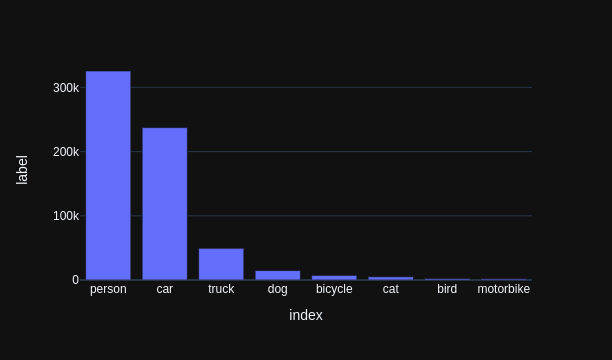

In [9]:
v_counts = df['label'].value_counts().reset_index()
px.bar(v_counts, y='label', x='index', height=300, width=500)

We can see that people and vehicles represent the vast majority of the dataset.

One idea would be to join cars and trucks into vehicles, the code for this operation is defined below.

In [10]:
idx = df['label'].isin(['car', 'truck'])
df.loc[idx, 'label'] = 'vehicle'

Now the vehicle class contains both object types: car and truck

### Keep only a single frame from the event's frame sequence

Let's assume that we have a person walking along the footpath. That person will be recognised in many frames, therefore many images of the same object will be captured. What we are interested in is only a single frame out of this sequence.

There are many methods to solve this, and it can get extremely complicated in a noisy environment with multiple objects inside the camera view.

Luckily in the case of studied dataset, the number of objects is relatevely low, so there is no need for any advanced movement tracking (for example using Kalman Filter method). 

This was one of the most challenging aspects of the project, and the algorithm I have used can be defined as below:
- sort data by time
- divide dataset by object type (label) and perform following tasks:
    - calculate difference in time between consecutive object observations
    - calculate **euclidean distance** between object centroids in consecutive frames, if it's the same observation in a sequence, then the center will be close to the previous center
    - keep only objects where the difference in time and distance are greater than the predefined thresholds (these have been set using heuristics)
    
Why Eucledian distance? It's the most common and simple measure of distance between $N$ points.

As defined in [iq.opengenus.org](https://iq.opengenus.org/euclidean-distance/):
Euclidean distance is the shortest distance between two points in an $N$ dimensional space also known as Euclidean space. It is used as a common metric to measure the similarity between two data points and used in various fields such as geometry, data mining, deep learning and others.

It is, also, known as Euclidean norm, Euclidean metric, L2 norm, L2 metric and Pythagorean metric.

$$
\sqrt{(x1-x2)^2+(y1-y2)^2}
$$

In [11]:
# dictionary to hold a dataframe per detected object class
dfs = {}

In [12]:
# these values seem to reject duplicates the best
THRESH_NEW_EVENT_SECS = 10  # how many seconds needs to elapse until we treat detection as a new observation
THRESH_NEW_EVENT_MIN_DISTANCE = 30  # min distance between 2 detections until we treat it as a new observation

In [13]:
# use this function to calculate euclidean distance between coordinates
def calc_distance(x):
    x_cur, y_cur, x_prev, y_prev = x
    return dist.cdist([[x_cur, y_cur]], [[x_prev, y_prev]], metric='euclidean')[0][0]

In [14]:
# sort observations chronologically
df = df.sort_values('date_time', ascending=True)

# create a separate DataFrame for each label of interest and save as a csv file
for l in ['vehicle', 'person']:
    
    print('Processing label: {}'.format(l))
    
    # filter out other objects from the data frame
    analysed_label_df = df.loc[df['label'].isin([l])].reset_index(drop=True).copy()
    
    # add a dummy variable, which we can use to count objects, there are most likely
    # better ways of doing this, but this one is simple and it works
    analysed_label_df['dummy_var'] = 1
    
    # calculate time difference between consecutive rows
    analysed_label_df['time_diff'] = analysed_label_df['date_time'].diff().fillna(pd.Timedelta(seconds=0))
    analysed_label_df['sec_diff'] = analysed_label_df['time_diff'].dt.total_seconds().fillna(0)
    analysed_label_df['x_center'] = analysed_label_df[['x1', 'x2']].mean(axis=1)
    analysed_label_df['y_center'] = analysed_label_df[['y1', 'y2']].mean(axis=1)

    # calculate euclidian distance between consecutive centroids (using x,y coordinates centroids)
    analysed_label_df['prev_x_center'] = analysed_label_df['x_center'].shift(1).fillna(0)
    analysed_label_df['prev_y_center'] = analysed_label_df['y_center'].shift(1).fillna(0)
    analysed_label_df['euc_distance'] = analysed_label_df[['x_center', 'y_center', 
        'prev_x_center', 'prev_y_center']].apply(calc_distance, axis=1)

    # keep only records within the rejection threshold
    idx = ((analysed_label_df['sec_diff'] > THRESH_NEW_EVENT_SECS) & 
           (analysed_label_df['euc_distance'] > THRESH_NEW_EVENT_MIN_DISTANCE))
    dfs[l] = analysed_label_df.loc[idx].reset_index(drop=True).copy()
    dfs[l].to_csv(f'../Datasets/UniqueObjectDetections__{l}__2019-09-09_2020-03-02.csv', index=False)

Processing label: vehicle
Processing label: person
